#All the imports we need

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

##Data loading

In [2]:
!wget https://github.com/curso-iabd-uclm/machinelearning/raw/main/insurance/train.csv

--2022-01-23 10:19:56--  https://github.com/curso-iabd-uclm/machinelearning/raw/main/insurance/train.csv
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/curso-iabd-uclm/machinelearning/main/insurance/train.csv [following]
--2022-01-23 10:19:57--  https://raw.githubusercontent.com/curso-iabd-uclm/machinelearning/main/insurance/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4942050 (4.7M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   4.71M  --.-KB/s    in 0.09s   

2022-01-23 10:19:57 (53.0 MB/s) - ‘train.csv’ saved [4942050/4942050]



In [3]:
df = pd.read_csv("train.csv")

##Preprocessing

Once we have downloaded and read train.csv, the first thing we are going to do is to **remove the null values** from this file.

In [4]:
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

The next step is to transform the **categorical features into numerical features**.

In [5]:
df_OneHot = pd.get_dummies(df[['Gender','MaritalStatus', 'PartTimeFullTime']])

In [6]:
df_full = pd.concat([df, df_OneHot], axis = 1)

# 1. BaseLine 


##Feature selection

For the feature selection we decided to exclude categorical, text-based and date-based features. In this context they are **'Gender', 'MaritalStatus', 'PartialFullTime', 'ClaimDescription', 'DateReported', 'DateTimeOfAccident', 'ClaimNumber', 'PartTimeFullTime'.**

In [7]:
exclude = ['Gender', 'MaritalStatus', 'PartialFullTime', 'ClaimDescription', 'DateReported', 'DateTimeOfAccident', 'ClaimNumber', 'PartTimeFullTime']
df_feature_selected = df_full.loc[:, df_full.columns.difference(exclude)]
df_feature_selected

,Age,DaysWorkedPerWeek,DependentChildren,DependentsOther,Gender_F,Gender_M,Gender_U,HoursWorkedPerWeek,InitialIncurredCalimsCost,MaritalStatus_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_F,PartTimeFullTime_P,UltimateIncurredClaimCost,WeeklyWages
0,48,5,0,0,0,1,0,38.0,1500,1,0,0,1,0,4748.203388,500.00
1,43,5,0,0,1,0,0,37.5,5500,1,0,0,1,0,6326.285819,509.34
2,30,5,0,0,0,1,0,38.0,1700,0,0,1,1,0,2293.949087,709.10
3,41,5,0,0,0,1,0,38.0,15000,0,1,0,1,0,17786.487170,555.46
4,36,5,0,0,0,1,0,38.0,2800,1,0,0,1,0,4014.002925,377.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36171,20,5,0,0,1,0,0,40.0,1400,0,1,0,1,0,1343.054886,344.16
36172,35,7,0,0,0,1,0,71.0,1000,1,0,0,1,0,172876.632600,1668.83
36173,52,4,0,0,1,0,0,20.0,500,1,0,0,0,1,632.281472,204.87
36174,28,5,0,0,0,1,0,38.0,4000,1,0,0,1,0,6714.495760,730.87


##Cross validation

We try cross validation dividing the dataset into a percentage of **70 for the training** and **30 for the test**, as we have decided to divide it in this way, so the algorithm has more training and will give us good results in the test.

In [8]:
train, test = train_test_split(df_feature_selected, test_size=0.30, random_state=42)

In [9]:
train.reset_index(drop = True, inplace = True)
train.head()

,Age,DaysWorkedPerWeek,DependentChildren,DependentsOther,Gender_F,Gender_M,Gender_U,HoursWorkedPerWeek,InitialIncurredCalimsCost,MaritalStatus_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_F,PartTimeFullTime_P,UltimateIncurredClaimCost,WeeklyWages
0,26,5,0,0,0,1,0,38.0,5000,0,0,1,1,0,8025.642527,200.00
1,27,5,0,0,1,0,0,38.0,13000,0,1,0,1,0,9977.454905,621.15
2,54,5,0,0,0,1,0,40.0,2300,1,0,0,1,0,3771.863681,606.00
3,25,5,0,0,0,1,0,40.0,500,0,1,0,1,0,771.820974,641.76
4,35,5,0,0,0,1,0,38.0,600,1,0,0,1,0,1392.230277,414.00


# 2. Optimized Model (RandomForests, Boosting + Hyperparameter Optimization)

##Random forests

First, we try the **randomized search** algorithm by establishing a set of parameters. Then, we execute the model in order **to look for the best parameters** and once we have found these parameters, we re-execute the model.

###Randomized Search

We create the **set of parameters** to be used during the optimization process

In [ ]:
param_dist = {"n_estimators": [8, 16, 32, 64, 128, 256, 512, 1024], # Number of trees in random forest
              "max_features": ['auto', 'sqrt'], # Number of features to consider at every split
              "max_depth": [4, 8, 16, None], # Maximum number of levels in tree
              "min_samples_split": sp_randint(10, 40), #  Minimum number of samples required to split a node
              "min_samples_leaf": sp_randint(1, 25), # Minimum number of samples required at each leaf node
              "bootstrap": [True, False], # Method of selecting samples for training each tree
              "criterion": ["mse", "mae"]}

We build our **regressor** to be tested

In [ ]:
regressor = RandomForestRegressor() 
regressor

RandomForestRegressor()

We execute the **randomized search** by making use of the set of parameters established

In [ ]:
rnd_regres = RandomizedSearchCV(estimator = regressor, param_distributions = param_dist, 
                               n_iter = 10, cv = 2, random_state=0, n_jobs = -1)

# Fit the random search model
rnd_regres.fit(X = train.drop(['UltimateIncurredClaimCost'], axis=1), 
                           y = train['UltimateIncurredClaimCost'])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['mse', 'mae'],
                                        'max_depth': [4, 8, 16, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f789c724090>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f789c720e90>,
                                        'n_estimators': [8, 16, 32, 64, 128,
                                                         256, 512, 1024]},
                   random_state=0)

We report the **results** obtained

In [17]:
def report(results, n_top=3): 
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
report(rnd_regres.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: 0.206 (std: 0.079)
Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 22, 'min_samples_split': 15, 'n_estimators': 512}

Model with rank: 2
Mean validation score: 0.195 (std: 0.084)
Parameters: {'bootstrap': True, 'criterion': 'mae', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 37, 'n_estimators': 64}

Model with rank: 3
Mean validation score: 0.191 (std: 0.083)
Parameters: {'bootstrap': True, 'criterion': 'mae', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 19, 'min_samples_split': 13, 'n_estimators': 8}

Model with rank: 4
Mean validation score: 0.160 (std: 0.075)
Parameters: {'bootstrap': False, 'criterion': 'mse', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 35, 'n_estimators': 256}

Model with rank: 5
Mean validation score: 0.146 (std: 0.020)
Parameters: {'bootstrap': True, 'criterion':

We find the **best parameters** in order to re-execute de model

In [ ]:
rnd_regres.best_params_

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 22,
 'min_samples_split': 15,
 'n_estimators': 512}

We re-execute the **model** with the **best parameters combination**

In [ ]:
# choose the best
best_random = rnd_regres.best_estimator_
# fit and predict
best_random.fit( X = train.drop(['UltimateIncurredClaimCost'], axis=1), y = train['UltimateIncurredClaimCost'])
y_pred = best_random.predict(X = test.drop(['UltimateIncurredClaimCost'], axis = 1))

# EVALUATE 
mae = mean_absolute_error(test['UltimateIncurredClaimCost'], y_pred)
print ('MAE', mae)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


MAE 7387.271110889784


We visualize the **results**

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


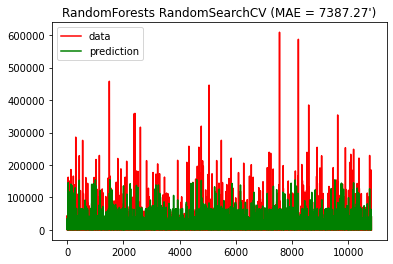

In [ ]:
xx = np.stack(i for i in range(test['UltimateIncurredClaimCost'].shape[0]))
plt.plot(xx, test['UltimateIncurredClaimCost'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests RandomSearchCV (MAE = %6.2f')" % ( mae))

plt.show()

##Grid search

We are going to execute **Grid Search** by using the **top 3 parameter combinations** found in the Randomized Search

In [13]:
param_grid = {"n_estimators": [8, 64, 512], # Number of trees in random forest
              "max_features": ['auto'], # Number of features to consider at every split
              "max_depth": [8,4, None], # Maximum number of levels in tree
              "min_samples_split": [37], #  Minimum number of samples required to split a node
              "min_samples_leaf": [19], # Minimum number of samples required at each leaf node
              "bootstrap": [True], # Method of selecting samples for training each tree
              "criterion": ["mse"]
            }

We build our **regressor** to be tested

In [14]:
regressor = RandomForestRegressor(criterion='squared_error') 
regressor

RandomForestRegressor()

We execute the **model**

In [15]:
grid_regres = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = 2)

# Fit the random search model
grid_regres.fit(X = train.drop(['UltimateIncurredClaimCost'], axis=1), 
                           y = train['UltimateIncurredClaimCost'])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

GridSearchCV(cv=2, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True], 'criterion': ['mse'],
                         'max_depth': [8, 4, None], 'max_features': ['auto'],
                         'min_samples_leaf': [19], 'min_samples_split': [37],
                         'n_estimators': [8, 64, 512]})

We visualize the **results**

In [18]:
report(grid_regres.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: 0.209 (std: 0.082)
Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 19, 'min_samples_split': 37, 'n_estimators': 64}

Model with rank: 2
Mean validation score: 0.205 (std: 0.079)
Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 19, 'min_samples_split': 37, 'n_estimators': 64}

Model with rank: 3
Mean validation score: 0.201 (std: 0.074)
Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 19, 'min_samples_split': 37, 'n_estimators': 64}

Model with rank: 4
Mean validation score: 0.200 (std: 0.073)
Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 19, 'min_samples_split': 37, 'n_estimators': 512}

Model with rank: 5
Mean validation score: 0.198 (std: 0.072)
Parameters: {'bootstrap': True, 'criterion'

##Boosting

For the boosting process we are going to perform a grid search by making use of **AdaBoosting** and **GradientBoosting**

###Grid search

We try grid search with AdaBoosting with a **number of estimator** from 8 to 128 growing exponentially, a **learning rate** of 0.05, 0.1 and 0.25 and a linear, square and exponential **loss**. Moreover, we will try the process with a **cross-validation of 2.**

In [ ]:
param_dist = {
 "n_estimators": [8, 32, 64, 128],
 "learning_rate" : [0.05, 0.1, 0.25],
 "loss" : ['linear', 'square', 'exponential']
 }

grid_ada = GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(criterion='mae')),
                        param_grid = param_dist, cv=2)

grid_ada.fit(X = train.drop(['UltimateIncurredClaimCost'], axis=1),y = train['UltimateIncurredClaimCost'])


best_ada = grid_ada.best_estimator_
print (best_ada)
# fit and predict
best_ada.fit( X = train.drop(['UltimateIncurredClaimCost'], axis=1), y = train['UltimateIncurredClaimCost'])
y_pred = best_ada.predict(X = test.drop(['UltimateIncurredClaimCost'], axis = 1))

# EVALUATE 
mae = mean_absolute_error(test['UltimateIncurredClaimCost'], y_pred)
print ('MAE', mae)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae'),
                  learning_rate=0.05, loss='exponential', n_estimators=32)
MAE 6186.6061747368285


As we can see, we have obtained a **mean absolute error** value of **6186.606** which is **less** than the mean absolute error value obtained with the best parameters in the randomized search applied to **random forest regressor** **(7387.271)**

We try grid search with GradientBoosting with a **number of estimator** from 32 to 128 growing exponentially, a **learning rate** of 0.01, 0.05, 0.1, 0.25 and 0.5, an auto and sqrt **max_features**, a ls, lad, huber and quantile **loss** and a mae and friedman_mse **criterion**. Moreover, we will try the process with a **cross-validation of 2.**

In [12]:
param_dist = {
 "n_estimators": [32, 64, 128],
 "learning_rate" : [0.01,0.05,0.1,0.25,0.5],
  "max_features" : ["auto", "sqrt"],
 "loss" : ['ls', 'lad', 'huber', 'quantile'],
 "criterion": ['mae', 'friedman_mse']
 }

grid_gb = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist, cv=2)

grid_gb.fit(X = train.drop(['UltimateIncurredClaimCost'], axis=1),y = train['UltimateIncurredClaimCost'])


best_gb = grid_gb.best_estimator_
print (best_gb)
# fit and predict
best_gb.fit( X = train.drop(['UltimateIncurredClaimCost'], axis=1), y = train['UltimateIncurredClaimCost'])
y_pred = best_gb.predict(X = test.drop(['UltimateIncurredClaimCost'], axis = 1))

# EVALUATE 
mae = mean_absolute_error(test['UltimateIncurredClaimCost'], y_pred)
print ('MAE', mae)

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/pyth

GradientBoostingRegressor(learning_rate=0.05, loss='quantile',
                          max_features='sqrt', n_estimators=64)
MAE 10785.869413520722


As we can see, we have obtained a **mean absolute error** value of **10785.869** which is **more** than the mean absolute error value obtained with the best parameters in the randomized search applied to **random forest regressor** **(7387.271)** and the MAE obtained with the Grid Search with **AdaBoosting (6186.606)**

#Conclusions

As we have seen in the previous steps, a **Grid Search** applied to an **AdaBoosting** regressor has obtained the **best results** in this case.
Moreover, we have seen the importance of using **Hyperparameter optimization**, which is really useful if we want to obtain more **accurated results**.
Finally, we want to remark the **strategy** followed in this task: perform a **Random Search** with an specific regressor and then perform a **Grid Search** with the **best results obtained** in the Random Search